## Load Lib

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import shutil
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Load Data


In [12]:
#load the dataset and look at the number of training and testing examples

print('Train Images = ',len(os.listdir('./train')))
print('Test Images = ',len(os.listdir('./test')))

Train Images =  220026
Test Images =  57458


In [13]:
#create a dataframe of train image labels

df = pd.read_csv('./train_labels.csv')
df[df['id'] != '9599d5019c25f6ca5f5d7a869b9bfd7bbb015601']

print('Shape of DataFrame',df.shape)

df.head()

Shape of DataFrame (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


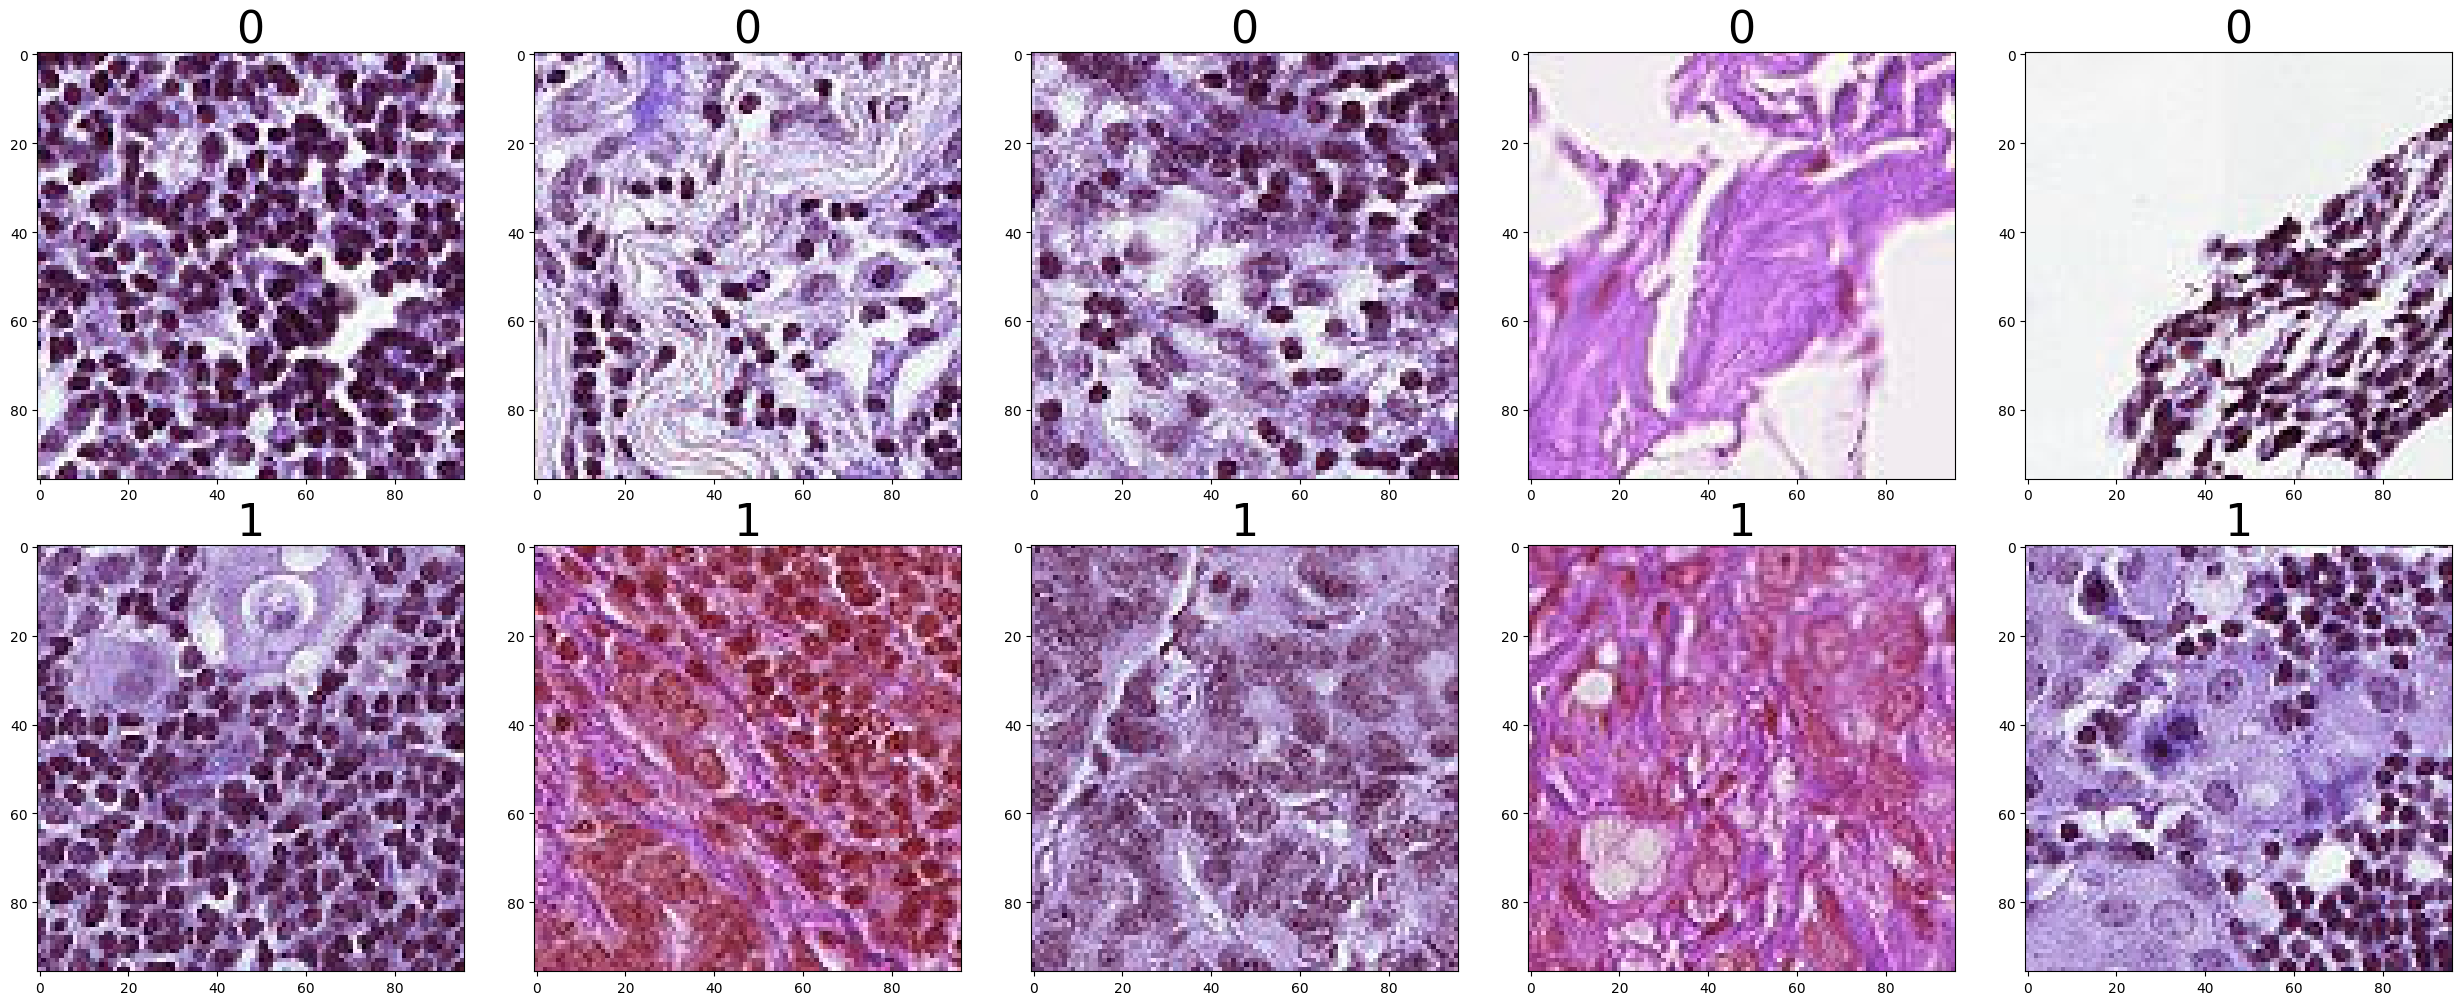

In [14]:
IMAGE_PATH = './train/' 
categories = (df.groupby(['label'])['label'].nunique()).index
f, ax = plt.subplots(nrows=len(categories),ncols=5, 
                        figsize=(5*5,5*len(categories))) 
for i, cat in enumerate(categories):
    sample = df[df['label']==cat].sample(5) 
    for j in range(0,5):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
        im=cv2.imread(file)
        ax[i, j].imshow(im, resample=True, cmap='gray')
        ax[i, j].set_title(cat, fontsize=32)  
plt.tight_layout()
plt.show()


In [15]:
# take a sample size of 60000 to avoid crashing
SAMPLE_SIZE = 80000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)

# shuffle
df_train.sample(frac=1)

df_train['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [16]:
# split into training and validation sets
y = df_train['label']

# stratify=y means that the train_test_split method returns training and test subsets 
# that have the same proportions of class labels as the input dataset.
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 0, stratify = y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [17]:
# Create a new directory
working_dir = 'working_dir'
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

# Folder Structure
'''
working_dir
    training_dir
        No_Tumor  #(negative)
        Has_Tumor #(positive)
    validation_dir
        No_Tumor  #(negative)
        Has_Tumor #(positive)
'''

# Create a path to 'working_dir' to which we will join the names of the new folders
# training_dir
training_dir = os.path.join(working_dir, 'training_dir')
if not os.path.exists(training_dir):
    os.mkdir(training_dir)

# validation_dir
validation_dir = os.path.join(working_dir, 'validation_dir')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

# Create new folders inside training_dir
neg = os.path.join(training_dir, 'No_Tumor')
if not os.path.exists(neg):
    os.mkdir(neg)
pos = os.path.join(training_dir, 'Has_Tumor')
if not os.path.exists(pos):
    os.mkdir(pos)

# Create new folders inside validation_dir
neg = os.path.join(validation_dir, 'No_Tumor')
if not os.path.exists(neg):
    os.mkdir(neg)
pos = os.path.join(validation_dir, 'Has_Tumor')
if not os.path.exists(pos):
    os.mkdir(pos)

In [18]:
print(os.listdir('working_dir/training_dir'))
print(os.listdir('working_dir/validation_dir'))

['Has_Tumor', 'No_Tumor']
['Has_Tumor', 'No_Tumor']


In [19]:
# Set the id as the index in df_data
df.set_index('id', inplace=True)

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'No_Tumor'
    elif target == 1:
        label = 'Has_Tumor'
    
    # source path to image
    src = os.path.join('./train', file_name)
    # destination path to image
    dest = os.path.join(training_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [20]:
print(len(os.listdir('working_dir/training_dir/No_tumor')))
print(len(os.listdir('working_dir/training_dir/Has_tumor')))

74943
77394


In [21]:
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    file_name = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'No_Tumor'
    elif target == 1:
        label = 'Has_Tumor'
    

    # source path to image
    src = os.path.join('./train', file_name)
    # destination path to image
    dest = os.path.join(validation_dir, label, file_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dest)

In [22]:
print(len(os.listdir('working_dir/validation_dir/No_tumor')))
print(len(os.listdir('working_dir/validation_dir/Has_tumor')))

10907
13405


## Data Augmentation

In [23]:
# Initialize an instance of ImageDataGenerator, a data augmentation class provided by Keras.
data_augmentation = ImageDataGenerator(
    rescale=1./255,  # Rescale the image pixel values to be between 0 and 1. This helps with the neural network's performance.
    horizontal_flip=True,  # Randomly flip inputs horizontally.
    vertical_flip=True,  # Randomly flip inputs vertically.
    rotation_range=180,  # Degree range for random rotations. Here, the image can be rotated in the range [-180, 180] degrees.
    zoom_range=0.4,  # Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
    width_shift_range=0.3,  # Shift the image horizontally by a fraction of its width. If a float, fraction of total width.
    height_shift_range=0.3,  # Shift the image vertically by a fraction of its height. If a float, fraction of total height.
    shear_range=0.3,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    channel_shift_range=0.3  # Range for random channel shifts. If a float, shifts each channel of the input RGB image.
)

In [24]:
# Set the batch size and image size for the ImageDataGenerator
batch_size = 192
image_size = 96

# Define the paths to the training, validation, and test directories
train_path = 'working_dir/training_dir'
val_path = 'working_dir/validation_dir'
test_path = 'working_dir/validation_dir'


# Use the previously defined data_augmentation ImageDataGenerator to load, augment, and batch the training images
train_set = data_augmentation.flow_from_directory(
    train_path,  # The path to the directory where the training images are stored
    target_size = (image_size,image_size),  # The dimensions to which all images found will be resized
    batch_size = batch_size,  # The size of the batches of data
    class_mode = 'binary'  # "binary" means that there are only two classes to predict, so binary labels are used
)

# Create a new ImageDataGenerator for the validation data. No augmentation is applied, but pixel values are rescaled to [0,1]
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,  # The path to the directory where the validation images are stored
    target_size = (image_size,image_size),  # The dimensions to which all images found will be resized
    batch_size = batch_size,  # The size of the batches of data
    class_mode = 'binary'  # "binary" means that there are only two classes to predict, so binary labels are used
)

# Create a new ImageDataGenerator for the test data. No augmentation is applied, but pixel values are rescaled to [0,1]
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,  # The path to the directory where the test images are stored
    target_size = (image_size,image_size),  # The dimensions to which all images found will be resized
    batch_size = batch_size,  # The size of the batches of data
    class_mode = 'binary',  # "binary" means that there are only two classes to predict, so binary labels are used
    shuffle = False  # Don't shuffle the input samples. This is important during testing, so you can match the predictions with the correct labels
)

Found 152337 images belonging to 2 classes.
Found 24312 images belonging to 2 classes.
Found 24312 images belonging to 2 classes.


In [25]:
print(train_set.samples)
print(val_set.samples)
print(test_set.samples)

152337
24312
24312


## Model

In [26]:
# Import necessary modules from Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define constants for the model
kernel_size = (3,3)  # Size of the filter matrix for our convolutional layers
pool_size= (2,2)  # Size of the pooling matrix for the pooling layers
first_filters = 32  # Number of filters in the first convolutional layer
second_filters = 64  # Number of filters in the second convolutional layer
third_filters = 128  # Number of filters in the third convolutional layer

dropout_conv = 0.3  # Dropout rate to be used after each Convolutional layer
dropout_dense = 0.3  # Dropout rate to be used after the Dense layer

# Start sequential model
model = Sequential()

# First conv block
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Second conv block
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Third conv block
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first dense layer
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))

# Last layer: it's a binary classification, so we use a sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

# Compile the model, defining the optimizer to use, the loss function, and the metrics to use for evaluation
model.compile(optimizer=Adam(decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model to review its structure and the number of parameters
model.summary()

c:\Users\rmezg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\rmezg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,660,929 (6.34 MB)

 Trainable params: 1,660,929 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

## Training

Epoch 1/15


c:\Users\rmezg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 26s/step - accuracy: 0.4969 - loss: 0.7381 - val_accuracy: 0.5514 - val_loss: 0.6927
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - accuracy: 0.5266 - loss: 0.6928 - val_accuracy: 0.5514 - val_loss: 0.6924
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - accuracy: 0.4976 - loss: 0.6933 - val_accuracy: 0.5514 - val_loss: 0.6924
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.4679 - loss: 0.6935 - val_accuracy: 0.4486 - val_loss: 0.6937
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.5219 - loss: 0.6927 - val_accuracy: 0.4486 - val_loss: 0.6967
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.4476 - val_loss: 0.6930
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.5161 - loss: 0.6930 - val_accuracy: 0.5514 - val_loss: 0.6921
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.5439 - loss: 0.6922 - val_accuracy: 0.5514 - val_loss: 0.6913
Epoch 9/15
4/4 ━━

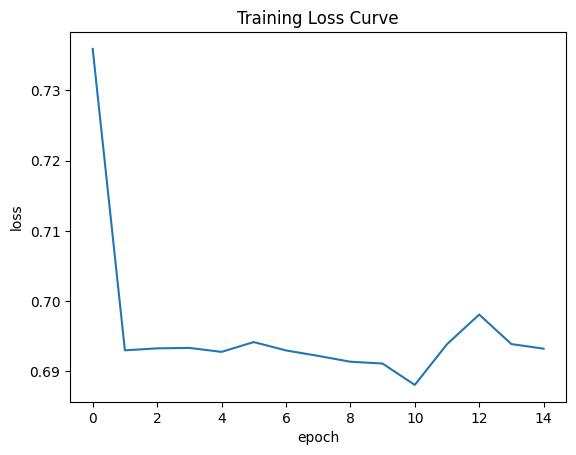

In [27]:
# Training

history = model.fit(train_set, 
                              validation_data=val_set,
                              steps_per_epoch=int(len(train_set)/batch_size) ,
                              validation_steps=int(len(val_set)/batch_size), 
                              epochs = 15,
                              verbose = 1,
                              )

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [28]:
print(test_set.samples)

24312


In [29]:
predictions = model.predict(test_set, steps = len(test_set), verbose = 1)

fpr, tpr, thresholds = roc_curve(test_set.classes, predictions)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step
AUC:  0.5572801577967494


In [30]:

val_loss, val_acc = \
model.evaluate(test_set, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.5540 - loss: 0.6914    
val_loss: 0.6914781332015991
val_acc: 0.5513737797737122


c:\Users\rmezg\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step
AUC:  0.5572801577967494
Optimal Threshold:  0.4911231


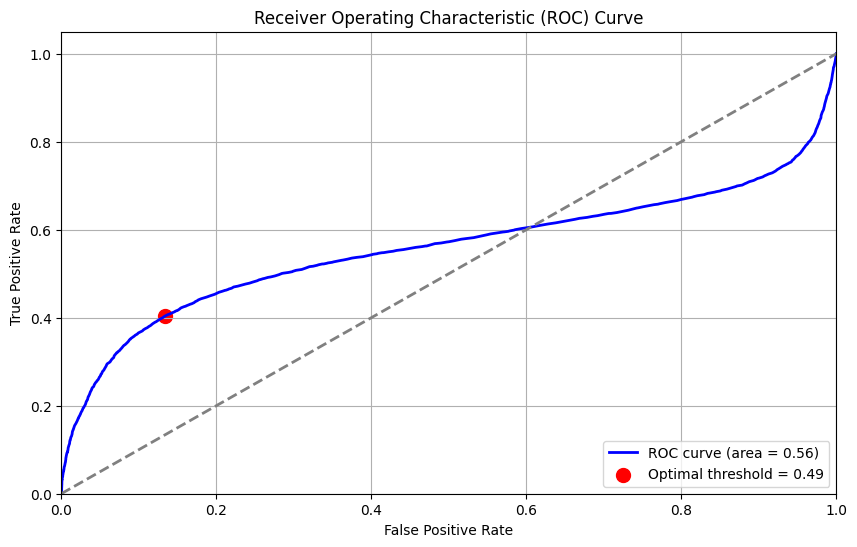

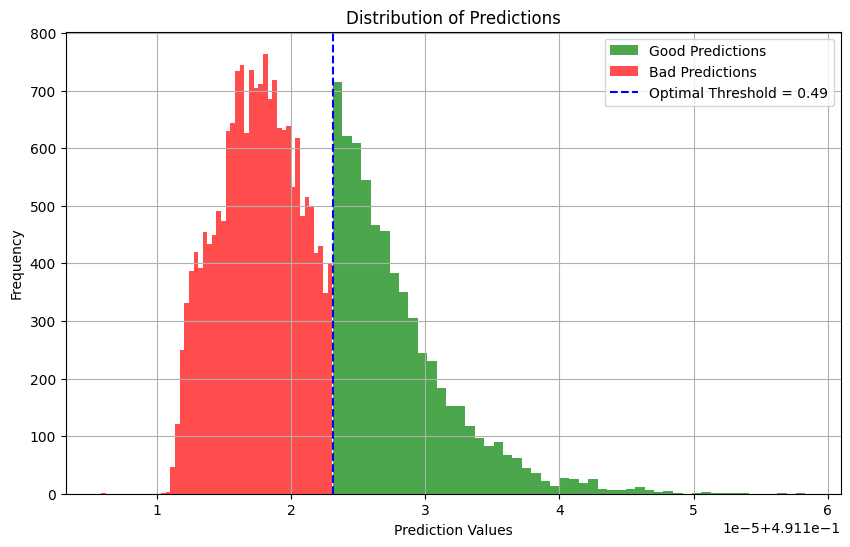

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Assuming `model` and `test_set` are already defined and used in your environment

# Generate predictions
predictions = model.predict(test_set, steps=len(test_set), verbose=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_set.classes, predictions)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

# Determine the optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold: ", optimal_threshold)

# Classify predictions as good or bad based on the optimal threshold
good_predictions = predictions >= optimal_threshold
bad_predictions = predictions < optimal_threshold

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Highlight the optimal threshold point
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}', s=100)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Show the plot
plt.show()

# Additionally, plot the histogram of predictions to visualize good and bad predictions
plt.figure(figsize=(10, 6))
plt.hist(predictions[good_predictions], bins=50, alpha=0.7, label='Good Predictions', color='green')
plt.hist(predictions[bad_predictions], bins=50, alpha=0.7, label='Bad Predictions', color='red')

plt.axvline(optimal_threshold, color='blue', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [1]:
from tf_explain.core.integrated_gradients import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Choose a sample image from your test set to explain
sample_image_batch, _ = next(iter(test_set))
sample_image = sample_image_batch[0]

# Initialize IntegratedGradients class
ig = IntegratedGradients()

# Explain a prediction using Integrated Gradients
explanation = ig.explain((sample_image[np.newaxis, ...], None), model, class_index=0)

# Rescale the explanation to be between 0 and 1
min_val = np.min(explanation[0])
max_val = np.max(explanation[0])
if min_val == max_val:
    explanation_rescaled = np.zeros_like(explanation[0])
else:
    explanation_rescaled = (explanation[0] - min_val) / (max_val - min_val)

# Resize the explanation to match the dimensions of the original image
explanation_resized = resize(explanation_rescaled, sample_image.shape[:2])

# Overlay the explanation on the original image
plt.imshow(sample_image)
plt.imshow(explanation_resized, cmap='hot', alpha=0.5, interpolation='nearest')  # Overlay the explanation using a heatmap colormap
plt.colorbar()  # Add color bar for the explanation
plt.savefig('integrated_gradients_overlay.png')


NameError: name 'test_set' is not defined

https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

Chat GPT

Github Copilot